In [ ]:
import math
import os
import sys
sys.path.append('..')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle, Circle
import matplotlib.animation as animation
from matplotlib import gridspec
from matplotlib.image import imread
import numpy as np
from scipy import stats

import config
import parser

IMG_DIR = '../../motion_distributions/data/train'

import warnings
warnings.filterwarnings('ignore')

# Importing and processing data

## Importing data

In [2]:
# Grabbing the trial data
trials = parser.parse_eyedata(
    os.path.join('..', 'data/pilots/', 'test/raw_sonia_full.asc'))

## Processing data

In [42]:
all_gaze_df = pd.DataFrame()
all_saccade_df = pd.DataFrame()
all_fixation_df = pd.DataFrame()
for idx, t in enumerate(trials):
    # Trial information
    t_idx = t['idx']
    scene_name = t['scene_name']
    # Get gaze data
    gaze_data = t['gaze']
    gaze_df = pd.DataFrame(gaze_data, columns=parser.Gaze._fields)
    gaze_df['scene_name'] = scene_name
    gaze_df['trial_index'] = t_idx
    all_gaze_df = pd.concat([all_gaze_df, gaze_df])
    # Get saccade data
    saccade_data = t['saccades']
    saccade_df = pd.DataFrame(saccade_data, columns=parser.Saccade._fields)
    saccade_df['scene_name'] = scene_name
    saccade_df['trial_index'] = t_idx
    all_saccade_df = pd.concat([all_saccade_df, saccade_df])
    # Get fixation data
    fixation_data = t['fixations']
    fixation_df = pd.DataFrame(fixation_data, columns=parser.Fixation._fields)
    fixation_df['scene_name'] = scene_name
    fixation_df['trial_index'] = t_idx
    all_fixation_df = pd.concat([all_fixation_df, fixation_df])

In [43]:
# Gaze data for intra trials
intra_trial_gaze_df = all_gaze_df[all_gaze_df.scene_name.str.contains('intra')]
intra_trial_gaze_df.scene_name = intra_trial_gaze_df.scene_name.apply(lambda x: x.replace('_intra', ''))
# Gaze data for pre trials
pre_trial_gaze_df = all_gaze_df[all_gaze_df.scene_name.str.contains('pre')]
pre_trial_gaze_df.scene_name = pre_trial_gaze_df.scene_name.apply(lambda x: x.replace('_pre', ''))
# Gaze data for post trials
post_trial_gaze_df = all_gaze_df[all_gaze_df.scene_name.str.contains('post')]
post_trial_gaze_df.scene_name = post_trial_gaze_df.scene_name.apply(lambda x: x.replace('_post', ''))

In [46]:
# Fixation data for intra trials
intra_trial_fixation_df = all_fixation_df[all_fixation_df.scene_name.str.contains('intra')]
intra_trial_fixation_df.scene_name = intra_trial_fixation_df.scene_name.apply(lambda x: x.replace('_intra', ''))
# Fixation data for pre trials
pre_trial_fixation_df = all_fixation_df[all_fixation_df.scene_name.str.contains('pre')]
pre_trial_fixation_df.scene_name = pre_trial_fixation_df.scene_name.apply(lambda x: x.replace('_pre', ''))
# Fixation data for post trials
post_trial_fixation_df = all_fixation_df[all_fixation_df.scene_name.str.contains('post')]
post_trial_fixation_df.scene_name = post_trial_fixation_df.scene_name.apply(lambda x: x.replace('_post', ''))

# Plotting data

## Plotting functions

### Raw gaze data

In [9]:
def plot(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    # Create a figure with gridspec
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    for i, scene_name in enumerate(scene_names[:10]):
        scene_df = df[df['scene_name'] == scene_name]
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            # Calculate padding
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            # Display image
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')  # Light gray background if image not found
        # Calculate KDE
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        # Plot scatter with color intensity based on KDE
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=0.2)
        all_densities.extend(z)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    # Remove any unused subplots
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    # Add a single colorbar on the right side of the figure
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin = min(all_densities)
    vmax = max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.savefig(fname=os.path.join('..', config.FIGURE_STORE, 'gaze_scatter.jpeg'), dpi=300)
    plt.close()

In [10]:
def plot_opacity_gradient(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1,
                           grid_size,
                           height_ratios=[1]*grid_size + [0.05],
                           wspace=0.05,
                           hspace=0)
    all_densities = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name]
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(
                img,
                extent=[
                    pad_left,
                    pad_left+img_width,
                    1080-pad_top,
                    1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        # Normalize time values to use as alpha
        time = scene_df['time'] - scene_df['time'].min()
        time_norm = (time - time.min()) / (time.max() - time.min())
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=time_norm, s=10)
        all_densities.extend(z)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm = plt.cm.ScalarMappable(
        cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(
        sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle(
        "Eye Gaze Data Across Scenes (Opacity = Time)", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.savefig(
        fname=os.path.join('..', config.FIGURE_STORE, 'gaze_opacity.jpeg'),
        dpi=300)
    plt.close()

In [11]:
def plot_directional_arrows(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=0.5, s=10)
        all_densities.extend(z)
        # Add directional arrows
        interval = len(x) // 10
        for j in range(0,len(x) - 1,interval):
            dx = x.iloc[j+1] - x.iloc[j]
            dy = y.iloc[j+1] - y.iloc[j]
            ax.arrow(x.iloc[j], y.iloc[j], dx, dy, 
                     head_width=60, head_length=60, fc='r', ec='r', alpha=0.6)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes (with Directional Arrows)", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.savefig(fname=os.path.join('..', config.FIGURE_STORE, 'gaze_direct_arrows.jpeg'), dpi=300)
    plt.close()

In [29]:
def plot_line_traces(
        df, filename, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    # Scaling factor for pupil
    PUPIL_SCALE = 100
    scene_names = df['scene_name'].unique()
    trial_idx = df['trial_index'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    # Generate figure and grid for figure
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(
        grid_size+3,
        grid_size,
        height_ratios=[1]*grid_size + [0.05,0.1,0.05],
        wspace=0.05,
        hspace=0.1)
    # Lists for the densities and times for each plot
    all_densities = []
    all_times = []
    # Enumerate over all scenes
    for i, scene_name in enumerate(scene_names):
        # Grab data for current scene, sort the values based on time
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        # Create axis object
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        # Grab the scene image
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        # Clip all of the x,y values to the limits of the screen
        x = scene_df['x'].clip(0, 1920)
        y = scene_df['y'].clip(0, 1080)
        xy = np.vstack([x, y])
        # Compute KDE
        z = stats.gaussian_kde(xy)(xy)
        # Grab time and pupil diameter values
        times = scene_df['time']
        pupils = list(scene_df['pupil'])
        pupils = list(map(lambda x: x/PUPIL_SCALE, pupils))
        # Create points and line segments from those points
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(times.min(), times.max())
        lc = LineCollection(segments, cmap='cool', norm=norm)
        lc.set_array(times[:-1])
        line = ax.add_collection(lc)
        # Create scater of eye gaze x,y values
        scatter = ax.scatter(
            x, y, c=z, cmap='Blues', alpha=0.5, s=pupils)
        all_densities.extend(z)
        all_times.extend(times)
        # Set axis parameters
        ax.set_title(f"Scene: {scene_name}, Idx: {trial_idx[i]}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        # Add clipping
        clip_rect = Rectangle((0, 0), 1920, 1080, fill=False)
        ax.add_patch(clip_rect)
        for artist in ax.get_children():
            artist.set_clip_path(clip_rect)
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    # Gaze density colorbar
    cbar_ax1 = fig.add_subplot(gs[-3, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm1 = plt.cm.ScalarMappable(
        cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm1.set_array([])
    cbar1 = plt.colorbar(sm1, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Gaze Density')
    # Time progression colorbar
    cbar_ax2 = fig.add_subplot(gs[-1, :])
    time_min, time_max = min(all_times), max(all_times)
    sm2 = plt.cm.ScalarMappable(
        cmap='cool', norm=plt.Normalize(time_min, time_max))
    sm2.set_array([])
    cbar2 = plt.colorbar(sm2, cax=cbar_ax2, orientation='horizontal')
    cbar2.set_label('Time Progression')
    # Format time labels
    def format_time(t, pos):
        return f"{(t - time_min) / 1e9:.1f}s"  # Assuming timestamps are in nanoseconds
    cbar2.ax.xaxis.set_major_formatter(plt.FuncFormatter(format_time))
    plt.suptitle(
        "Eye Gaze Data Across Scenes (with Time Traces)", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.savefig(fname=os.path.join('..', config.FIGURE_STORE, filename), dpi=300)
    plt.close()

In [13]:
def plot_animated(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png', interval=1, save_path=True):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    scatter_plots = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        scatter = ax.scatter([], [], c='blue', alpha=0.5, s=10)
        scatter_plots.append((scatter, x, y, z))
        all_densities.extend(z)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes (Animated)", fontsize=16, y=0.92)
    def animate(frame):
        for scatter, x, y, z in scatter_plots:
            scatter.set_offsets(np.c_[x[:frame], y[:frame]])
            scatter.set_array(z[:frame])
        return [scatter for scatter, _, _, _ in scatter_plots]
    anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=interval, blit=True, repeat=False)
    if save_path:
        anim.save('test2.mp4', writer='ffmpeg', fps=60)
    else:
        plt.show()
    return anim

### Fixation data

In [ ]:
def plot_fixations(df, filename, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0.1)
    all_durations = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x'].clip(0, 1920)
        y = scene_df['y'].clip(0, 1080)
        durations = scene_df['stop'] - scene_df['start']
        all_durations.extend(durations)
        # Plot fixation circles
        circles = [Circle((xi, yi), radius=10 + 40 * (di / durations.max())) for xi, yi, di in zip(x, y, durations)]
        fixations = PatchCollection(circles, cmap='viridis', alpha=0.6)
        fixations.set_array(durations)
        ax.add_collection(fixations)
        # Plot arrows between fixations
        for j in range(len(x) - 1):
            ax.annotate("", xy=(x.iloc[j+1], y.iloc[j+1]), xytext=(x.iloc[j], y.iloc[j]),
                        arrowprops=dict(arrowstyle="->", color="r", alpha=0.5))
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        # Add clipping
        clip_rect = Rectangle((0, 0), 1920, 1080, fill=False)
        ax.add_patch(clip_rect)
        for artist in ax.get_children():
            artist.set_clip_path(clip_rect)
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    # Fixation duration colorbar
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_durations), max(all_durations)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Fixation Duration (seconds)')
    plt.suptitle("Eye Fixation Data Across Scenes", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.savefig(fname=os.path.join('..', config.FIGURE_STORE, filename), dpi=300)
    plt.close()

### Saccade data

In [15]:
def plot_saccades(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0.1)
    all_velocities = []
    all_times = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('start')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        start_x = scene_df['start_x'].clip(0, 1920)
        start_y = scene_df['start_y'].clip(0, 1080)
        end_x = scene_df['end_x'].clip(0, 1920)
        end_y = scene_df['end_y'].clip(0, 1080)
        velocities = scene_df['peak_vel']
        times = scene_df['start']
        all_velocities.extend(velocities)
        all_times.extend(times)
        # Plot saccades as arrows
        for j in range(len(start_x)):
            ax.annotate("", xy=(end_x.iloc[j], end_y.iloc[j]), xytext=(start_x.iloc[j], start_y.iloc[j]),
                        arrowprops=dict(arrowstyle="->", color=plt.cm.viridis(velocities.iloc[j]/velocities.max()), 
                                        alpha=0.7, linewidth=1 + 2 * (velocities.iloc[j]/velocities.max())))
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        # Add clipping
        clip_rect = Rectangle((0, 0), 1920, 1080, fill=False)
        ax.add_patch(clip_rect)
        for artist in ax.get_children():
            artist.set_clip_path(clip_rect)
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    # Peak velocity colorbar
    cbar_ax1 = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_velocities), max(all_velocities)
    sm1 = plt.cm.ScalarMappable(cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    sm1.set_array([])
    cbar1 = plt.colorbar(sm1, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Peak Velocity (degrees/second)')
    plt.suptitle("Eye Saccade Data Across Scenes", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.savefig(os.path.join('..', config.FIGURE_STORE, 'saccades.jpeg'), dpi=300)
    plt.close()

## Generating plots

### Raw gaze data

In [48]:
plot_line_traces(pre_trial_gaze_df, 'pre_line_plot.pdf')

In [ ]:
plot_line_traces(intra_trial_gaze_df, 'intra_line_plot.pdf')

In [49]:
plot_line_traces(post_trial_gaze_df, 'post_line_plot.pdf')

### Fixation data

In [50]:
plot_fixations(pre_trial_fixation_df, 'pre_fixation_plot.pdf')

In [51]:
plot_fixations(intra_trial_fixation_df, 'intra_fixation_plot.pdf')

In [52]:
plot_fixations(post_trial_fixation_df, 'postfixation_plot.pdf')

### Saccade data

In [20]:
plot_saccades(all_saccade_df)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_39888/272453682.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


# Other analyses

In [ ]:
intra_trial_gaze_df.groupby('trial_index').x.apply()

,time,x,y,pupil,fixation,saccade,blink,event,scene_name,trial_index
0,1017.091,1189.0,250.4,1279.0,False,False,False,None,scene_1_1,0
1,1017.092,1189.3,250.4,1276.0,False,False,False,None,scene_1_1,0
2,1017.093,1189.5,250.5,1274.0,False,False,False,None,scene_1_1,0
3,1017.094,1189.2,250.5,1271.0,False,False,False,None,scene_1_1,0
4,1017.095,1189.0,250.6,1269.0,False,False,False,None,scene_1_1,0
...,...,...,...,...,...,...,...,...,...,...
4270,2278.716,970.0,566.6,1202.0,True,False,False,fixation,med_yescol_nosp_2,105
4271,2278.717,969.4,566.4,1201.0,True,False,False,fixation,med_yescol_nosp_2,105
4272,2278.718,968.8,566.3,1201.0,True,False,False,fixation,med_yescol_nosp_2,105
4273,2278.719,968.5,566.6,1201.0,True,False,False,fixation,med_yescol_nosp_2,105


In [ ]:
def analyze_vertical_gaze(df):
    """
    Analyzes vertical gaze patterns from eye tracking data.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'y' and 'trial_index'
    
    Returns:
    dict: Analysis metrics for vertical gaze patterns
    """
    # Group by trial_index
    trials = df.groupby('trial_index')
    
    # Calculate metrics
    metrics = {
        'mean_y_position': trials['y'].mean(),
        'y_variance': trials['y'].var(),
        'y_range': trials.agg({'y': lambda x: x.max() - x.min()}),
        'lower_half_proportion': trials.apply(
            lambda x: (x['y'] > x['y'].median()).mean()
        ),
        'quartile_time': trials.apply(
            lambda x: {
                'q1_time': (x['y'] <= x['y'].quantile(0.25)).mean(),
                'q2_time': ((x['y'] > x['y'].quantile(0.25)) & 
                           (x['y'] <= x['y'].quantile(0.50))).mean(),
                'q3_time': ((x['y'] > x['y'].quantile(0.50)) & 
                           (x['y'] <= x['y'].quantile(0.75))).mean(),
                'q4_time': (x['y'] > x['y'].quantile(0.75)).mean()
            }
        )
    }
    
    # Calculate overall metrics
    summary = {
        'overall_mean_y': df['y'].mean(),
        'overall_y_std': df['y'].std(),
        'total_vertical_distance': df['y'].diff().abs().sum(),
        'vertical_velocity': df['y'].diff().abs().mean(),
        'downward_bias_score': (df['y'] > df['y'].mean()).mean()
    }
    
    return metrics, summary

In [55]:
metrics, summary = analyze_vertical_gaze(intra_trial_gaze_df)

In [57]:
summary

{'overall_mean_y': 586.1835474558222,
 'overall_y_std': 220.12823251709617,
 'total_vertical_distance': 151197.8,
 'vertical_velocity': 0.4225574038053077,
 'downward_bias_score': 0.47411106794814106}

In [ ]:
def plot_downward_bias(df, figsize=(12, 6), rolling_window=5):
    """
    Creates a visualization of downward bias across trials using seaborn.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with 'y' and 'trial_index' columns
    figsize (tuple): Figure size (width, height)
    rolling_window (int): Window size for rolling average
    
    Returns:
    matplotlib.figure.Figure: The created figure
    """
    # Calculate downward bias for each trial
    trial_bias = df.groupby('trial_index').apply(
        lambda x: (x['y'] > x['y'].mean()).mean()
    ).reset_index()
    trial_bias.columns = ['trial_index', 'downward_bias']
    
    # Calculate rolling average
    trial_bias['rolling_avg'] = trial_bias['downward_bias'].rolling(
        window=rolling_window, center=True
    ).mean()
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create main scatter plot
    sns.scatterplot(
        data=trial_bias,
        x='trial_index',
        y='downward_bias',
        alpha=0.4,
        color='skyblue',
        label='Individual Trials'
    )
    
    # Add rolling average line
    sns.lineplot(
        data=trial_bias,
        x='trial_index',
        y='rolling_avg',
        color='navy',
        linewidth=2,
        label=f'{rolling_window}-Trial Rolling Average'
    )
    
    # Add reference line at 0.5 (neutral bias)
    plt.axhline(
        y=0.5,
        color='red',
        linestyle='--',
        alpha=0.5,
        label='Neutral Bias (0.5)'
    )
    
    # Customize plot
    plt.title('Downward Gaze Bias Across Trials', pad=20)
    plt.xlabel('Trial Index')
    plt.ylabel('Downward Bias Score\n(>0.5 indicates downward bias)')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add annotations
    mean_bias = trial_bias['downward_bias'].mean()
    plt.text(
        0.02, 0.98,
        f'Mean Bias: {mean_bias:.3f}',
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    return plt.gcf()

The line `x['y'].mean()` calculates the average y-position for a given trial.

`x['y'] > x['y'].mean()` creates a boolean array where True means gaze was above average y-position.

`(x['y'] > x['y'].mean()).mean()` averages these booleans to get proportion of time spent above average.

The logic is as follows:
1. Y coordinates typically increase going down the screen
2. So values above the mean y-position represent looking lower on screen
3. The final score is between 0-1, where:
    - 0.5 means equal time above/below mean (neutral)
    - 0.5 means more time looking down
    - <0.5 means more time looking up

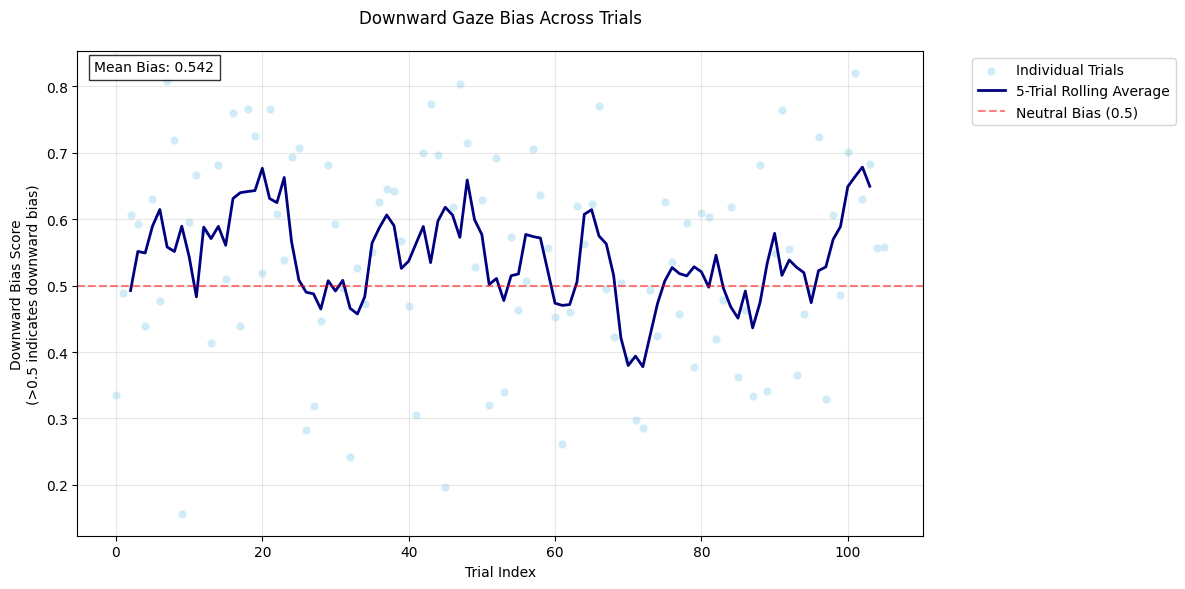

In [60]:
# Create and display the plot
fig = plot_downward_bias(intra_trial_gaze_df)
plt.show()

In [ ]:
def analyze_vertical_movement(df):
    """
    Analyzes vertical eye movements using position changes between samples.
    """
    # Calculate y position changes
    df['y_change'] = df['y'].diff()
    
    # Group by trial_index
    trials = df.groupby('trial_index')
    
    # Calculate metrics based on directional changes
    metrics = {
        'downward_movement_ratio': trials.apply(
            lambda x: (x['y_change'] > 0).mean()  # Proportion of downward movements
        ),
        'mean_vertical_velocity': trials['y_change'].mean(),
        'downward_velocity_sum': trials.apply(
            lambda x: x['y_change'][x['y_change'] > 0].sum()  # Total downward distance
        ),
        'upward_velocity_sum': trials.apply(
            lambda x: abs(x['y_change'][x['y_change'] < 0].sum())  # Total upward distance
        )
    }
    
    return metrics

# Visualization function
def plot_movement_bias(df, figsize=(12, 6), rolling_window=5):
    """
    Visualizes downward movement bias across trials.
    """
    metrics = analyze_vertical_movement(df)
    
    movement_data = pd.DataFrame({
        'trial_index': metrics['downward_movement_ratio'].index,
        'movement_bias': metrics['downward_movement_ratio'].values
    })
    
    # Add rolling average
    movement_data['rolling_avg'] = movement_data['movement_bias'].rolling(
        window=rolling_window, center=True
    ).mean()
    
    plt.figure(figsize=figsize)
    
    sns.scatterplot(
        data=movement_data,
        x='trial_index',
        y='movement_bias',
        alpha=0.4,
        color='skyblue',
        label='Individual Trials'
    )
    
    sns.lineplot(
        data=movement_data,
        x='trial_index',
        y='rolling_avg',
        color='navy',
        linewidth=2,
        label=f'{rolling_window}-Trial Rolling Average'
    )
    
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Equal Up/Down')
    plt.title('Vertical Movement Bias Across Trials')
    plt.xlabel('Trial Index')
    plt.ylabel('Proportion of Downward Movements')
    
    plt.tight_layout()
    return plt.gcf()

In [83]:
def compare_gaze_metrics(df):
    """Compare position-based and movement-based gaze analysis"""
    # Position-based analysis
    position_bias = df.groupby('trial_index').apply(
        lambda x: (x['y'] > x['y'].mean()).mean()
    ).reset_index()
    position_bias.columns = ['trial_index', 'position_bias']
    
    # Movement-based analysis
    df['y_change'] = df['y'].diff()
    movement_bias = df.groupby('trial_index').apply(
        lambda x: (x['y_change'] > 0).mean()
    ).reset_index()
    movement_bias.columns = ['trial_index', 'movement_bias']
    
    # Combine metrics
    combined = pd.merge(position_bias, movement_bias, on='trial_index')
    
    # Create subplot comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Position-based plot
    sns.scatterplot(data=combined, x='trial_index', y='position_bias', 
                   alpha=0.4, ax=ax1, color='skyblue')
    sns.lineplot(data=combined, x='trial_index', 
                y=combined['position_bias'].rolling(5).mean(),
                color='navy', ax=ax1)
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    ax1.set_title('Position-Based Analysis')
    ax1.set_ylabel('Time Below Mean Y-Position')
    
    # Movement-based plot
    sns.scatterplot(data=combined, x='trial_index', y='movement_bias', 
                   alpha=0.4, ax=ax2, color='skyblue')
    sns.lineplot(data=combined, x='trial_index', 
                y=combined['movement_bias'].rolling(5).mean(),
                color='navy', ax=ax2)
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('Movement-Based Analysis')
    ax2.set_ylabel('Proportion of Downward Movements')
    
    plt.tight_layout()
    
    # Calculate correlation
    correlation = combined['position_bias'].corr(combined['movement_bias'])
    print(f"Correlation between metrics: {correlation:.3f}")
    
    return fig, combined

Correlation between metrics: -0.152


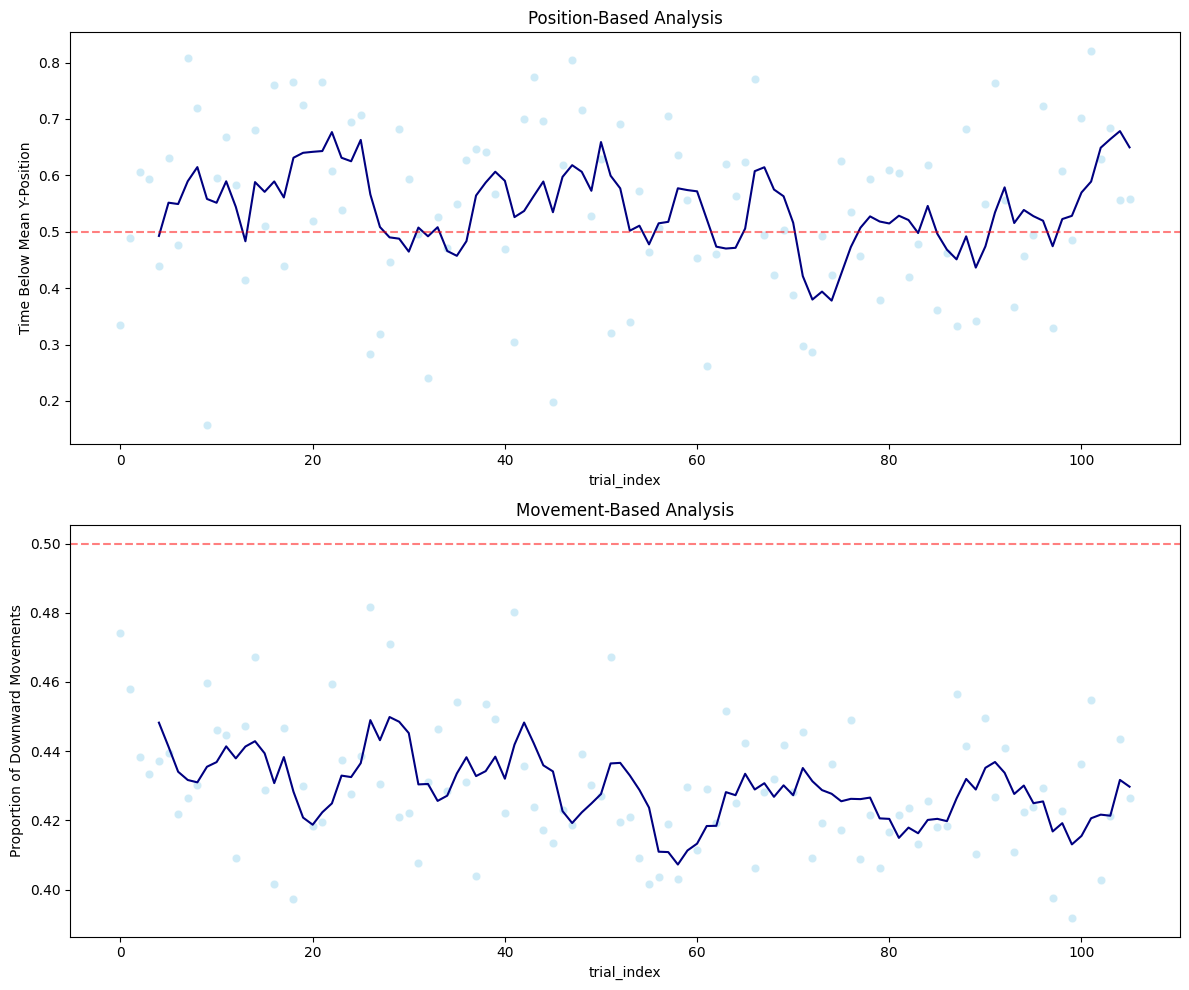

In [85]:
fig, metrics = compare_gaze_metrics(intra_trial_gaze_df)
plt.savefig('../data/figures/gaze_pattern_analysis.pdf', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>